<a href="https://colab.research.google.com/github/niz11/Bachelor_Thesis_Colab_Files/blob/main/RepeatVector_dots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.models import load_model
from keras.models import model_from_json
import json

# load json and create model
json_file = open('drive/My Drive/dots_encoder_decoder_models/encoderDots2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
encoder = model_from_json(loaded_model_json)
# load weights into new model
encoder.load_weights("drive/My Drive/dots_encoder_decoder_models/encoderDots2.h5")
print("Loaded model from disk")

# load json and create model
json_file = open('drive/My Drive/dots_encoder_decoder_models/decoderDots2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
decoder = model_from_json(loaded_model_json)
# load weights into new model
decoder.load_weights("drive/My Drive/dots_encoder_decoder_models/decoderDots2.h5")
print("Loaded model from disk")

Loaded model from disk
Loaded model from disk


In [ ]:
import numpy as np

# Load encoding
encoded = np.load('drive/My Drive/dots_encoded/encoding_dot_trainig.npy')
encoded_test = np.load('drive/My Drive/dots_encoded/encoding_dot_test.npy')

In [ ]:
from keras import backend as K
import matplotlib.pyplot as plt

trainng_size = encoded.shape[0]
test_size = encoded_test.shape[0]
# data preperation
# X - 10 encoding of pictures 
# Y - 10 future frames encoding
# wanted goal: (samples: 5000, time-steps: 10, features: 64 )
# y = (sample index 5000, 10, 64 wanted feature)

sequence_length = 10
future_prediction = 10
encoding_length = 64
# X = (10000,10,64)
X = np.zeros(shape=(trainng_size // sequence_length //2,sequence_length,encoding_length))
X_zeros = np.zeros(shape=(trainng_size // sequence_length //2,sequence_length,encoding_length))
# x = (10,64)
x = np.zeros(shape=(sequence_length,encoding_length))
# y = (10000,10,64)
y = np.zeros(shape=(trainng_size // sequence_length //2,sequence_length,encoding_length))
# y_seq = (10,64)
y_seq = np.zeros(shape=(future_prediction,encoding_length))
i = 1
seq_index = 0
while (i < trainng_size - future_prediction):
      if i%sequence_length != 0:
        x[i%sequence_length - 1] = encoded[i-1]
        i += 1
      else:
          x[sequence_length - 1] = encoded[i-1]
          for j in range(1,future_prediction + 1):
            y_seq[j - 1] = encoded[i + j - 1]
          y[seq_index] = y_seq
          X[seq_index] = x
          x = np.zeros(shape=(sequence_length,encoding_length))
          y_seq = np.zeros(shape=(future_prediction,encoding_length))
          i += sequence_length + 1
          seq_index +=1
# y is one step, each seq of 20 can produce 10 labels
# Or each seq is exactly one sample and label
# X_test = (20, 10, 64)
X_test = np.zeros(shape=(test_size // sequence_length - 1, sequence_length, encoding_length))
X_test_zero = np.zeros(shape=(test_size // sequence_length - 1, sequence_length, encoding_length))
# x_test = (10, 64)
x_test = np.zeros(shape=(sequence_length,encoding_length))
# y_test = (20, 10, 64)
y_test = np.zeros(shape=(test_size // sequence_length - 1, sequence_length ,encoding_length))
# y_test = (10, 64)
y_seq_test = np.zeros(shape=(sequence_length ,encoding_length))
i = 1
seq_index = 0
# to fix: test set had starting index 99 zero input values
while (i < test_size - future_prediction):
      if i%sequence_length != 0:
        x_test[i%sequence_length - 1] = encoded_test[i-1]
        i += 1
      else:
          x_test[sequence_length - 1] = encoded_test[i-1]
          for j in range(1,future_prediction + 1):
            y_seq_test[j - 1] = encoded_test[i + j - 1]
          y_test[seq_index] = y_seq_test
          X_test[seq_index] = x_test
          x_test = np.zeros(shape=(sequence_length,encoding_length))
          y_seq_test = np.zeros(shape=(future_prediction,encoding_length))
          i += sequence_length + 1
          seq_index +=1

X_swaped_order = np.zeros(shape=(trainng_size // sequence_length //2,sequence_length,encoding_length))
X_swaped_order_zeros = np.zeros(shape=(trainng_size // sequence_length //2,sequence_length,encoding_length))
decoder_future_inputs = np.zeros(shape=(trainng_size // sequence_length //2,sequence_length,encoding_length))
decoder_future_inputs_zeros = np.zeros(shape=(trainng_size // sequence_length //2,sequence_length,encoding_length))
for i in range(X.shape[0]):
  for j in range(X.shape[1]):
    # X_swaped_order[i,j] = X[i, 9 - j]
    # Make first vecotr and move all to the right
    if j == 0:
      # First frame of the future sequence
      X_swaped_order[i,j] = y[i,0]
    else:
      X_swaped_order[i,j] = X[i, 10 - j]
    if j == 0:
      # Last frame from the input
      # decoder_future_inputs[i,j] = X[i,9]
      # Make first vecotr and move all to the right
      decoder_future_inputs[i,j] = X[i,9]
    else:
        # decoder_future_inputs[i,j] = y[i,j]
        decoder_future_inputs[i,j] = y[i,j - 1]


X_test_swaped_order = np.zeros(shape=(test_size // sequence_length - 1, sequence_length, encoding_length))
X_test_swaped_order_zeros = np.zeros(shape=(test_size // sequence_length - 1, sequence_length, encoding_length))
decoder_test_future_inputs = np.zeros(shape=(test_size // sequence_length - 1, sequence_length, encoding_length))
decoder_test_future_inputs_zeros = np.zeros(shape=(test_size // sequence_length - 1, sequence_length, encoding_length))
for i in range(X_test.shape[0]):
  for j in range(X_test.shape[1]):
    # X_test_swaped_order[i,j] = X_test[i, 9 - j]
    # Make first vecotr and move all to the right
    if j == 0:
      X_test_swaped_order[i,j] = y_test[i,0]
    else:
      X_test_swaped_order[i,j] = X_test[i, 10 - j]
    if j == 0:
      # Last frame from the input
      # decoder_test_future_inputs[i,j] = X_test[i,9]
      decoder_test_future_inputs[i,j] = X_test[i, 9]
    else:
      # All output frames from future output but the last
      decoder_test_future_inputs[i,j] = y_test[i,j - 1]


print(X.shape)
print(np.array(y).shape)
print(X_test.shape)
print(np.array(y_test).shape)
print(decoder_future_inputs.shape)
print(decoder_test_future_inputs.shape)

(4900, 10, 64)
(4900, 10, 64)
(199, 10, 64)
(199, 10, 64)
(4900, 10, 64)
(199, 10, 64)


In [ ]:
import keras
from keras.layers import Input, Flatten, Dense,LSTM,TimeDistributed,RepeatVector
from keras.models import Model,Sequential
from keras.utils import plot_model


def create_model(encoding_length=64,sequence_length=10):
  visible = Input(shape=(sequence_length,encoding_length))
  encoder_outputs, state_h, state_c = LSTM(encoding_length, activation='relu', name='encoder', return_state=True)(visible)
  encoder_state = [state_h, state_c]
  
  # Reconstruct decoder
  decoder1 = RepeatVector(sequence_length)(encoder_outputs)
  decoder1 = LSTM(encoding_length, activation='relu', return_sequences=True)(decoder1, initial_state=encoder_state)
  decoder1 = LSTM(encoding_length,return_sequences=True)(decoder1)
  # For each time step in the output, we add a Dense layer that will try to minimize the distance from the real time step value 
  decoder1 = TimeDistributed(Dense(encoding_length))(decoder1)

  # Future prediciton decoder
  decoder2 = RepeatVector(sequence_length)(encoder_outputs)
  decoder2 = LSTM(encoding_length, activation='relu', return_sequences=True)(decoder2, initial_state=encoder_state)
  decoder2 = LSTM(encoding_length,return_sequences=True)(decoder2)
  decoder2 = TimeDistributed(Dense(encoding_length))(decoder2)

  model = Model(inputs=visible, outputs=[decoder1, decoder2])


  model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

  encoder = Model(inputs=model.input,
                      outputs=model.get_layer('encoder').output[0])
  model.summary()
  return model, encoder

In [ ]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import datetime
import os

model, encoder = create_model()

epochs = 50
batch_size = 10
# checkpoint
checkpoint_path = "drive/My Drive/composite_model_repeatvector_checkpoints/cp-{epoch:04d}.ckpt"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 period=5,
                                                 verbose=1)


logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model.fit(X,[X,y],validation_split=0.05, epochs=epochs,batch_size=batch_size, verbose=2, shuffle=False, callbacks=[cp_callback])

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 64)]     0                                            
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 64), (None,  33024       input_2[0][0]                    
__________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)  (None, 10, 64)       0           encoder[0][0]                    
__________________________________________________________________________________________________
repeat_vector_3 (RepeatVector)  (None, 10, 64)       0           encoder[0][0]                    
_______________________________________________________________________________________

In [ ]:
predictions_trainig = model.predict(X)
predictions_test= model.predict(X_test)

In [ ]:
def plotAutoEncoder(y, prediction,n, last_10=None):
  if n == 10:
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(y[i].reshape(64, 64))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(prediction[i].reshape(64, 64))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
  else:
      plt.figure(figsize=(20, 4))
      for i in range(n):
          ax = plt.subplot(2, n, i + 1)
          if i < 10:
            plt.imshow(prediction[i].reshape(64, 64))
          else:
            plt.imshow(last_10[i - 10].reshape(64, 64))

          plt.gray()
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)
      plt.show()

def plotFuture(y, prediction,n, first_10=None):
  if n == 10:
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(y[i].reshape(64, 64))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(prediction[i].reshape(64, 64))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
  else:
      plt.figure(figsize=(20, 4))
      for i in range(n):
          ax = plt.subplot(2, n, i + 1)
          if i < 10:
            plt.imshow(first_10[i].reshape(64, 64))
          else:
            plt.imshow(prediction[i - 10].reshape(64, 64))

          plt.gray()
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)
      plt.show()


In [ ]:
# Each time it pickes and decode one sequence
present = 0
future = 1
# Pick a random sequance
randomSmaple = np.random.randint(1000, size=1)
randomSmaple_test = np.random.randint(99, size=1)
print(randomSmaple[0])
print(randomSmaple_test[0])
# Decode y and y_test
y_decoded = decoder.predict(y[randomSmaple[0]])
y_decoded_test = decoder.predict(y_test[randomSmaple_test[0]])
# Autoencoders predictions
decoded_present = decoder.predict(predictions_trainig[present][randomSmaple[0]])
true_present_train = decoder.predict(X[randomSmaple[0]])
true_present_test = decoder.predict(X_test[randomSmaple_test[0]])
# Future predictions
decoded_future_training= decoder.predict(predictions_trainig[future][randomSmaple[0]])
decoded_present_test = decoder.predict(predictions_test[present][randomSmaple_test[0]])


# Future predictions
decoded_future_test= decoder.predict(predictions_test[future][randomSmaple_test[0]])


69
5


Autoencode
On trainig set


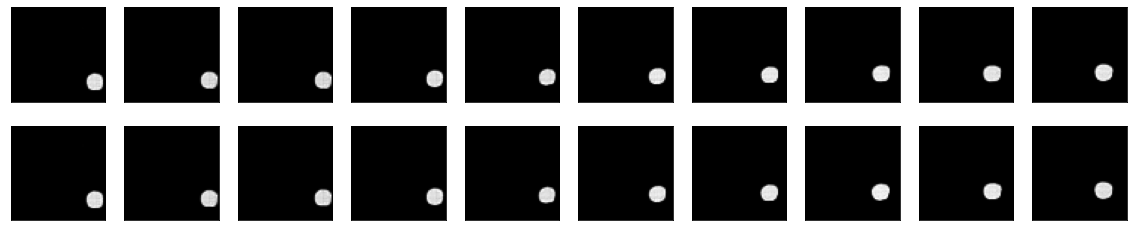

My prediction: the first 10:


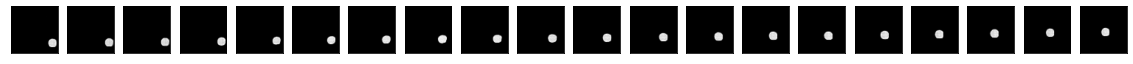

On test set


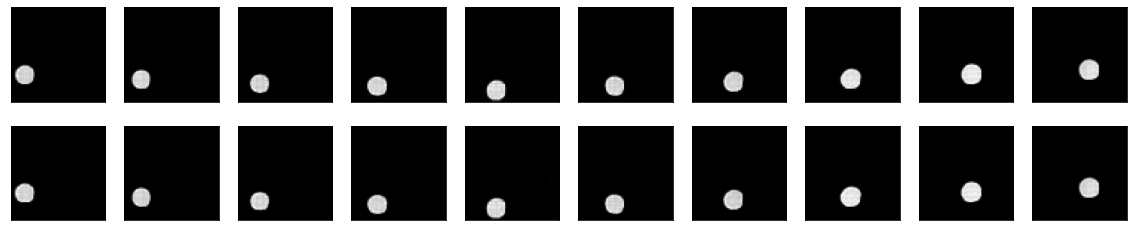

My prediction: the first 10:


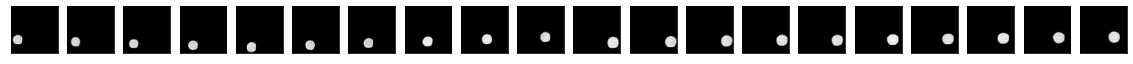

Future predictions
On training set


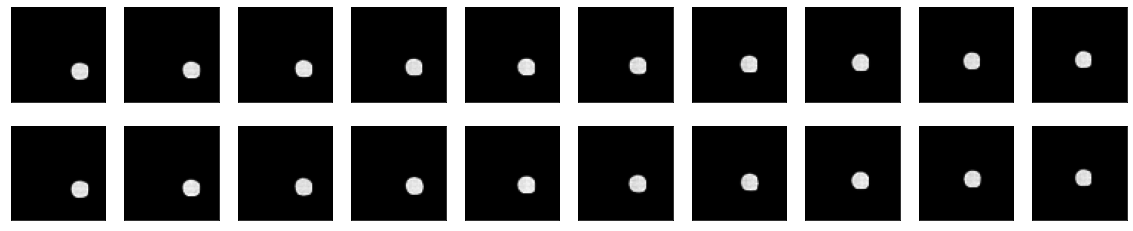

My prediction: the last 10:


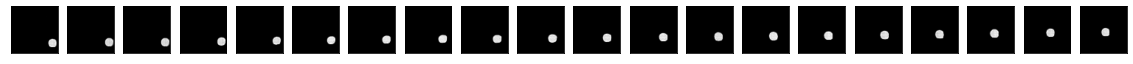

On test set


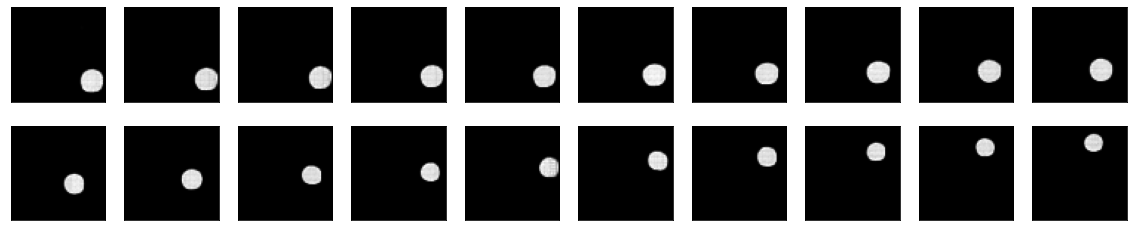

My prediction: the last 10:


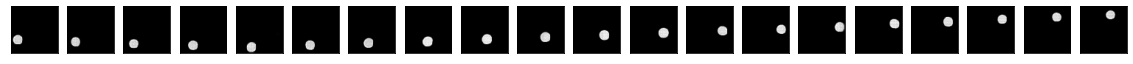

In [ ]:
print("Autoencode")
print("On trainig set")
plotAutoEncoder(true_present_train,decoded_present,10)
print("My prediction: the first 10:")
plotAutoEncoder(y_decoded,decoded_present,20, y_decoded)
print("On test set")
plotAutoEncoder(true_present_test,decoded_present_test,10)
print("My prediction: the first 10:")
plotAutoEncoder(y_decoded_test,decoded_present_test,20, y_decoded_test)
print("Future predictions")
print("On training set")
plotFuture(y_decoded,decoded_future_training,10)
print("My prediction: the last 10:")
plotFuture(y_decoded,decoded_future_training,20, true_present_train)
print("On test set")
plotFuture(y_decoded_test,decoded_future_test,10)
print("My prediction: the last 10:")
plotFuture(y_decoded_test,decoded_future_test,20, decoded_present_test)